# **Model Training**



## **1. Project Setup**

### 1.1 Import Libraries

In [1]:
%load_ext autoreload
%autoreload 

import sys
import os

# Add the module's parent directory to sys.path
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)

from lcz_classification.config import *
from lcz_classification.util import read_lcz_legend, normalize_arr, prepare_dataset, dataset_stats, dataset_summary
from lcz_classification.dataset import fetch_metadata
from lcz_classification.plots import plot_confusion_matrix, plot_feature_importances
from lcz_classification.modelling.train import predictor_stack
import rioxarray as rio

import numpy as np
import pandas as pd
from shapely.geometry import box
import geopandas as gpd
from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold, RandomizedSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import make_scorer, f1_score, recall_score,precision_score
from sklearn.metrics import confusion_matrix,accuracy_score, classification_report
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.ndimage import median_filter
import rasterio as r
from lcz_classification.util import merge_rasters, clip_raster
from lcz_classification.util import tiles_from_bbox


- Parent directory for Toronto already exists, retrievine folder paths...
- Folder paths for Toronto retrieved.


## 1.2 Setup Paths

In [2]:
s2_metadata=fetch_metadata('S2_METADATA')
lcz_legend, color_dict=read_lcz_legend(LCZ_LEGEND_FP)
label_dict=lcz_legend.set_index('class')['name'].to_dict()

study_area=fetch_metadata('STUDY_AREA')
study_area=study_area.to_crs(study_area.estimate_utm_crs())
tiles=tiles_from_bbox(study_area.total_bounds, tile_dims=(2,2))

### Load Data

In [3]:
# Read Feature Layers
# SF_FP = f'{SF_PRC}/svf_20m.tif'
# Sentinel-2A Imargery
s2=rio.open_rasterio(S2_FP)
attrs=s2.attrs
s2 = s2 / 10000
s2.attrs = attrs
s2_arr = s2.values


shape=s2.shape
s2_ref=s2.sel(band=1)
## URBAN CANOPY PARAMETERS ##
bh=rio.open_rasterio(BH_FP).rio.reproject_match(s2_ref) # Building Height
ch=rio.open_rasterio(CH_FP).rio.reproject_match(s2_ref) # Tree Canopy Height
isf=rio.open_rasterio(IS_FP).rio.reproject_match(s2_ref) # Impervious Surface Fraction
bsf=rio.open_rasterio(BS_FP).rio.reproject_match(s2_ref) # Building Surface Fraction
svf=rio.open_rasterio(SF_FP).rio.reproject_match(s2_ref) # Building Surface Fraction

features=eval(s2.attrs['bands'])
s2_b_filtered=s2_metadata[(s2_metadata.mission == "S2A" )& (s2_metadata.band.isin(features))].set_index('band').loc[features]
features=[f'{r.description} ({b})' for b,r in s2_b_filtered.iterrows()]
features.extend(['Building Height', 'Canopy Height', 'Impervious Surface Fraction', 'Building Surface Fraction', 'Sky View Factor'])

# Prepare Feature Stack
X_data=np.append(s2_arr,bh.fillna(0).values, axis=0)
X_data=np.append(X_data,ch.fillna(0).values, axis=0)
X_data=np.append(X_data,isf.fillna(0).values, axis=0)
X_data=np.append(X_data,bsf.fillna(0).values, axis=0)
X_data=np.append(X_data,svf.fillna(0).values, axis=0)

# Rescale Features
scaler=MinMaxScaler()
X_features= np.array([normalize_arr(x, scaler) for x in X_data])

In [4]:

def predictor_stack(features):
    return np.stack(features).reshape(features.shape[0],-1).T


### Train, Validation and Test Split

In [5]:
# Read Train / Test Data
train=rio.open_rasterio(TRAIN_FP).rio.reproject_match(s2_ref) # Local Climate Zones Rasterized (Target Layer)
train_arr=train.values

y_mask=train_arr[0] > 0
mask_shape=y_mask.shape


y=np.int16(train_arr[0][y_mask].reshape(-1))
X =  predictor_stack(np.array([x[y_mask] for x in X_features]))

X_train,X_test, y_train, y_test= train_test_split(X,y,test_size=0.3,stratify=y, random_state=42)
# Prepare Training Dataset
# X_train, y_train = prepare_dataset(X_features, train,features)


# # Prepare Testing Dataset
# X_test, y_test = prepare_dataset(X_features, test,features)

# Print Summary of Dataset and Classess
train_stats=dataset_stats(X_train, y_train, label_dict)
# val_stats=dataset_stats(X_val, y_val, label_dict)
test_stats=dataset_stats(X_test, y_test, label_dict)
dataset_summary(train_stats, test_stats)
# labels=[label_dict[x] for x in np.int16(np.unique(y))]


============== DATASET SUMMARY ==============
+--------+---------+----------+---------+
| Datset | Samples | Features | Classes |
+--------+---------+----------+---------+
| Train  |  32865  |    14    |    12   |
|  Test  |  14086  |    14    |    12   |
+--------+---------+----------+---------+

============-==== CLASS SUMMARY =================
+--------------------+-------+------+
|       Class        | Train | Test |
+--------------------+-------+------+
| Compact High-Rise  |  1548 | 664  |
|   Open High-Rise   |  2722 | 1166 |
|   Open Mid-Rise    |  1100 | 471  |
|   Open Low-Rise    |  6397 | 2741 |
|   Large low-rise   |  4777 | 2047 |
|   Sparsely built   |  1816 | 778  |
|    Dense trees     |  1851 | 794  |
|  Scattered trees   |  1053 | 451  |
|     Low plants     |  5655 | 2424 |
| Bare rock or paved |  995  | 427  |
| Bare soil or sand  |  1289 | 553  |
|       Water        |  3662 | 1570 |
+--------------------+-------+------+


## Train RandomForest Classifier

In [6]:

classes=[label_dict[int(x)] for x in np.unique(y_train)]

# Model Tuning with Grid Search

In [7]:
import joblib

MODEL_DIR="../models/"
MODEL_NAME='rf_cv_ronto'
RF_FP=f"{MODEL_DIR}/{MODEL_NAME}.joblib"

SEARCH_METHOD = "random"

search_methods=dict(
    random=RandomizedSearchCV,
    grid=GridSearchCV
)


cv = StratifiedKFold(n_splits=5, shuffle=True)

param_grid = {
    'n_estimators': [ 100, 200, 500], #[100, 150, 200, 500]
    'max_features': ['sqrt', 'log2'], #['auto', 'sqrt', 'log2']
    'criterion': ['gini', 'entropy'], #['gini', 'entropy']
    'max_depth' : [10, 20, None],
    'min_samples_split' : [2,5,10],
    'min_samples_leaf' : [2,5,10],
    'max_samples' : [0.2, 0.5, 0.8],
    'max_leaf_nodes' : [100, 1000, 3000]
    # 'class_weight' : ['balanced', 'balanced_subsample' ,None]
}

if os.path.exists(RF_FP):
    print(f'Train Random Forest Classifier found : {RF_FP}: Loading from File')
    # To load the model later
    cl = joblib.load(RF_FP)

    

else:
    print(f'- No Existing Model Found, running grid search with params:')

   
    print(param_grid)

    # Instantiate RandomForestClassifier without Hyperparameters set
    cl = RandomForestClassifier(n_jobs=-1)
    search=search_methods[SEARCH_METHOD]

    search=search(cl, param_grid, scoring='accuracy', cv =cv, verbose=1, n_jobs=-1, return_train_score=True )
    search.fit(X_train,y_train)
    print(f'- Best Parameters:{search.best_params_}')
    cv_results=pd.DataFrame(search.cv_results_)

    print(F'Mean Train Score: {cv_results.mean_train_score.mean().round(2)}')
    print(F'Mean Test Score: {cv_results.mean_test_score.mean().round(2)}')
    print()
    cv_results.to_csv(f"../models/{MODEL_NAME}.csv")
    # Retrieve the best estimator from grid search
    cl=search.best_estimator_
    cl.feature_names_in_ = np.array(features) # Set feature names
    cl.classes_ = np.array(features) 



- No Existing Model Found, running grid search with params:
{'n_estimators': [100, 200, 500], 'max_features': ['sqrt', 'log2'], 'criterion': ['gini', 'entropy'], 'max_depth': [10, 20, None], 'min_samples_split': [2, 5, 10], 'min_samples_leaf': [2, 5, 10], 'max_samples': [0.2, 0.5, 0.8], 'max_leaf_nodes': [100, 1000, 3000]}
Fitting 5 folds for each of 10 candidates, totalling 50 fits
- Best Parameters:{'n_estimators': 500, 'min_samples_split': 5, 'min_samples_leaf': 2, 'max_samples': 0.5, 'max_leaf_nodes': 3000, 'max_features': 'sqrt', 'max_depth': None, 'criterion': 'entropy'}
Mean Train Score: 0.88
Mean Test Score: 0.85



### Model Evaluation

In [8]:

cl.fit(X_train,y_train)
y_pred=cl.predict(X_test) # Predict on testing set

from sklearn.metrics import f1_score, precision_score, recall_score, balanced_accuracy_score

for avg in ['macro', 'micro', 'weighted']:
    f1=f1_score(y_test,y_pred, average=avg)
    re=recall_score(y_test,y_pred,average='macro')
    oabu = balanced_accuracy_score(y_test,y_pred)
    oaw=recall_score(y_test,y_pred,average='weighted')
    print(oaw)
    print(f"{avg}: {f1}")

0.8817265369870794
macro: 0.8470091552944171
0.8817265369870794
micro: 0.8817265369870794
0.8817265369870794
weighted: 0.8790256115646734


                    precision    recall  f1-score   support

 Compact High-Rise       0.86      0.81      0.84       664
    Open High-Rise       0.69      0.69      0.69      1166
     Open Mid-Rise       0.77      0.47      0.58       471
     Open Low-Rise       0.88      0.92      0.90      2741
    Large low-rise       0.87      0.89      0.88      2047
    Sparsely built       0.71      0.62      0.66       778
       Dense trees       0.93      0.98      0.96       794
   Scattered trees       0.92      0.92      0.92       451
        Low plants       0.97      0.97      0.97      2424
Bare rock or paved       0.75      0.94      0.83       427
 Bare soil or sand       0.96      0.91      0.94       553
             Water       1.00      1.00      1.00      1570

          accuracy                           0.88     14086
         macro avg       0.86      0.84      0.85     14086
      weighted avg       0.88      0.88      0.88     14086



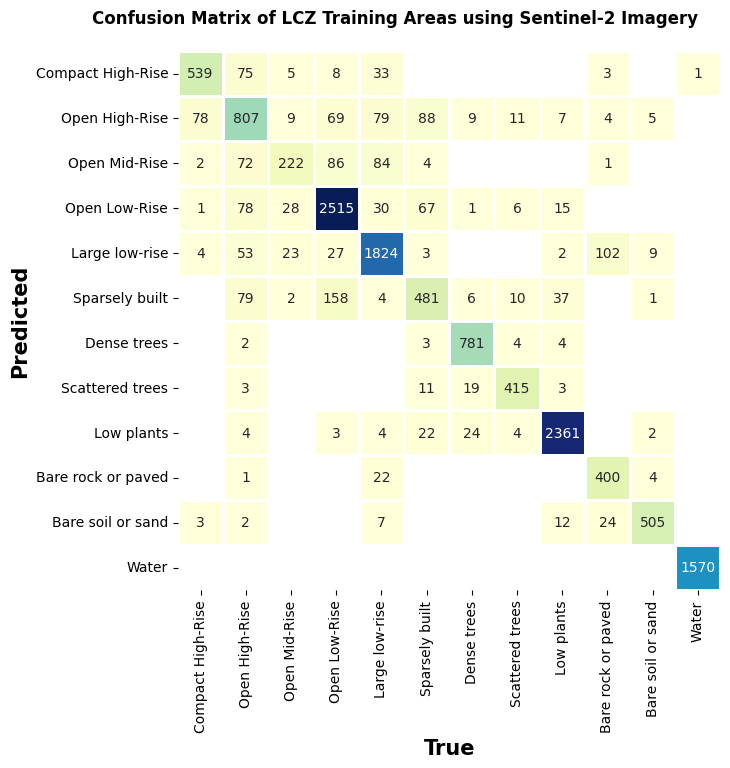

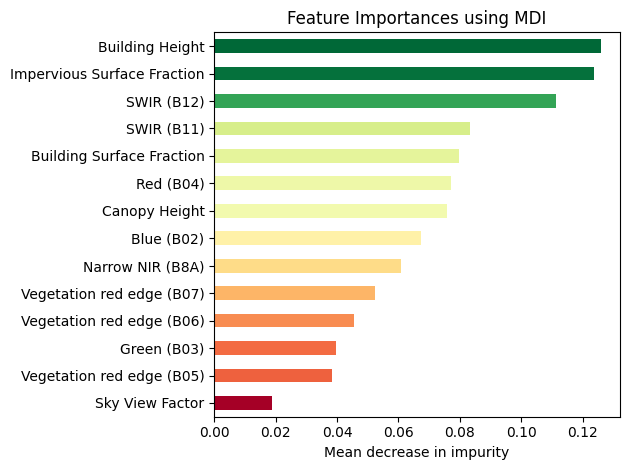

In [9]:

# Classification Report
cl_report=classification_report(y_test,y_pred,digits=2,target_names=classes)
cl_report_df=pd.DataFrame(classification_report(y_test,y_pred,digits=2,target_names=classes, output_dict=True)).T.round(2)
cl_report_df.support = cl_report_df.support.astype(int)
cl_report_df.to_csv("../reports/classification_report.csv")
print(cl_report)


out_file=f"{FIGURES_DIR}/s2_cm.png"

# Confustion Matridx
plot_confusion_matrix(
                    y_test=y_test,
                    y_pred=y_pred,
                    title='Confusion Matrix of LCZ Training Areas using Sentinel-2 Imagery',
                    labels=classes,
                    cmap='YlGnBu', 
                    as_percent=False, 
                    out_file=out_file, 
                    figsize = (7,7)
                    )


# Feature Importances
out_file=f"{FIGURES_DIR}/s2_fi.png"


plot_feature_importances(cl,features,"Feature Importances using MDI", out_file=out_file)



## Classify LCZs

In [10]:

def masked_features(features, ref, bounds):
    x1,y1,x2,y2 = bounds
    
    mask_raster=ref.sel(x = slice(x1,x2) ,y=slice(y2,y1), drop =False)
    mask_coords=mask_raster.coords
    mask_shape=mask_raster.shape
    mask=((ref.y > y1) & (ref.y < y2) & (ref.x > x1) & (ref.x < x2)).values

    feature_mask=np.array([mask for i in range(0, features.shape[0])])

    masked =  features[feature_mask].reshape(-1, mask_shape[0], mask_shape[1])

    return masked, mask_coords, mask_shape

def predictor_stack(features):
    return np.stack(features).reshape(features.shape[0],-1).T


def classify(cl, predictors, out_shape):
    classified=cl.predict(predictors)
    return classified.reshape(out_shape)

In [12]:
# Fit the classifier with the full dataset
cl.fit(X,y)

ref=s2.sel(band=1) # get reference raster

# ## Predict Class on whole dataset
X_predictors = s2.values
X_predictors = predictor_stack(X_features)
print(f"Predicting RandomForest Classifier on whole dataset size: {X.shape[0]:,} pixels")
classified=classify(cl, X_predictors,ref.shape)
smooth=median_filter(classified, size=(3,3)) # Remove "Salt and Pepper" effect
smooth=smooth.reshape(1, mask_shape[0], mask_shape[1])

out_file=f'../data/toronto/processed/classification/classified_{CELL_RESOLUTION}m.tif'

with r.open(
    out_file,
    mode="w",
    transform=ref.rio.transform(),
    height=ref.shape[0],
    width=ref.shape[1],
    count=1,
    dtype=np.int16,
    crs=s2.rio.crs,
    drive="GTiff",
) as predicted:
    predicted.write(smooth)


Predicting RandomForest Classifier on whole dataset size: 46,951 pixels


In [13]:
clip_raster(
    raster_path=out_file,
    gdf=study_area,
    bbox=None,
    out_path=out_file.replace(".tif", '_clip.tif'), 
    nodata=-32767,
    crs=s2.rio.crs
    
)

Clipped classified_30m.tif
Exported clipped raster for classified_30m.tif
